# Задание 
Попробуйте обучить методом Transfer Learning одну из готовых архитектур 
* ResNet, 
* VGG,
* etc. 

используя датасет кошки против собак - 

https://www.microsoft.com/en-us/download/details.aspx?id=54765
или
https://www.kaggle.com/c/dogs-vs-cats/data

## Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential

2022-10-18 21:19:53.616965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 21:19:53.734068: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-18 21:19:53.760595: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 21:19:54.276657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-10-18 21:19:55.020518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 21:19:55.025785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 21:19:55.025850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Подготовка данных

In [3]:
import glob
imgs_cat = glob.glob("PetImages/Cat/*.jpg")
imgs_dog = glob.glob("PetImages/Dog/*.jpg")
print(imgs_count := len(imgs_cat) + len(imgs_dog))

25000


In [4]:
cat_df = pd.DataFrame({'filename':imgs_cat, 'label':"cat"})
dog_df = pd.DataFrame({'filename':imgs_dog, 'label':"dog"})
total_df = pd.concat([cat_df, dog_df], ignore_index=True)
display(total_df)

,filename,label
0,PetImages/Cat/3661.jpg,cat
1,PetImages/Cat/7736.jpg,cat
2,PetImages/Cat/12352.jpg,cat
3,PetImages/Cat/9805.jpg,cat
4,PetImages/Cat/957.jpg,cat
...,...,...
24995,PetImages/Dog/4504.jpg,dog
24996,PetImages/Dog/1505.jpg,dog
24997,PetImages/Dog/5701.jpg,dog
24998,PetImages/Dog/4563.jpg,dog


### Визуализация

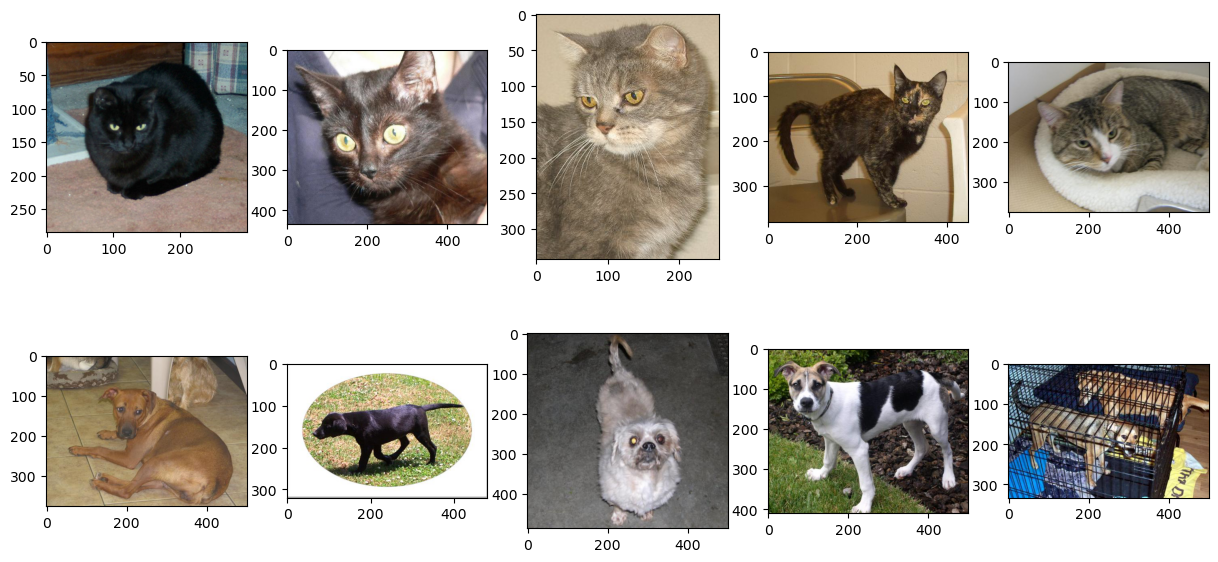

In [5]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat_df),5), start=1):
    im = img.imread(cat_df.loc[c, 'filename'])
    plt.subplot(2,5,i)
    plt.imshow(im)
    
for i, c in enumerate(np.random.randint(0,len(dog_df),5), start=6):
    im = img.imread(dog_df.loc[c, 'filename'])
    plt.subplot(2,5,i)
    plt.imshow(im)

### Разбиение на тренировочную и проверочную выборку

In [6]:
train_set, valid_set = train_test_split(total_df, test_size=0.2)
print(f"Train set shape {train_set.shape}")
print(f"Validation set shape {train_set.shape}")

Train set shape (20000, 2)
Validation set shape (20000, 2)


In [7]:
print(f"Train set distribution: \n{train_set['label'].value_counts()}")
print(f"\nValidation set distribution: \n{valid_set['label'].value_counts()}")


Train set distribution: 
dog    10030
cat     9970
Name: label, dtype: int64

Validation set distribution: 
cat    2530
dog    2470
Name: label, dtype: int64


### Дата генератор

In [14]:
WIDTH, HEIGHT = 75, 75 # для нормирование размера изображения
batch_size = 32

def convertDFtoArray(_set):
    X_train, Y_train = [], []
    for i in range(len(_set)):
        try:
            row = _set.iloc[i]
            img = cv2.imread(row['filename'])
            img = cv2.resize(img, (WIDTH, HEIGHT))
            X_train.append(img)
            Y_train.append([1, 0] if row['label'] == 'cat' else [0, 1])
        except: 
            pass
    return np.array(X_train), np.array(Y_train)


In [15]:
X_train, Y_train = convertDFtoArray(train_set)
X_test, Y_test = convertDFtoArray(valid_set)

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9
Corrupt JPEG data: 232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1408 extraneous bytes before marker 0xd9
Corrupt JPEG data: 104 extraneous bytes before marker 0xd9
Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: 402 extraneous bytes before marker 0xd9
Corrupt JPEG data: 259 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1158 extraneous bytes before marker 0xd9
Corrupt JPEG data: 133 extraneous bytes before marker 0xd9
Corrupt JPEG data: 217 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 70 extraneous bytes before marker 0xd9


## Модель

In [108]:
def createTLNN(opt):
    model = Sequential()
    
    modelTL = tf.keras.applications.resnet50.ResNet50(input_shape = (WIDTH, HEIGHT, 3), include_top = False, weights = 'imagenet')
    #modelTL.trainable = False
    for layer in modelTL.layers:
        if layer.name == 'conv5_block1_0_conv':
            break
        layer.trainable=False
    model.add(modelTL)

    model.add(L.Flatten()) #2048
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(2, activation='softmax'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### SGD Optimizer

In [66]:
optSGD = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelSGD = createTLNN(optSGD)

In [67]:
modelSGD.fit(X_train, Y_train, batch_size=32, epochs=10,
          verbose=1)

Epoch 1/10
624/624 [==============================] - 24s 35ms/step - loss: 0.3252 - accuracy: 0.8707
Epoch 2/10
624/624 [==============================] - 21s 33ms/step - loss: 0.1721 - accuracy: 0.9281
Epoch 3/10
624/624 [==============================] - 21s 33ms/step - loss: 0.1261 - accuracy: 0.9509
Epoch 4/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0769 - accuracy: 0.9713
Epoch 5/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0693 - accuracy: 0.9772
Epoch 6/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0604 - accuracy: 0.9821
Epoch 7/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0428 - accuracy: 0.9856
Epoch 8/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0342 - accuracy: 0.9902
Epoch 9/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0331 - accuracy: 0.9904
Epoch 10/10
624/624 [==============================] - 21s 33ms/step - loss: 0.036

#### SGD Results

In [68]:
modelSGD.evaluate(X_test, Y_test)

157/157 [==============================] - 5s 25ms/step - loss: 0.4321 - accuracy: 0.9067


[0.43209168314933777, 0.9066693186759949]

1/1 [==============================] - 0s 29ms/step


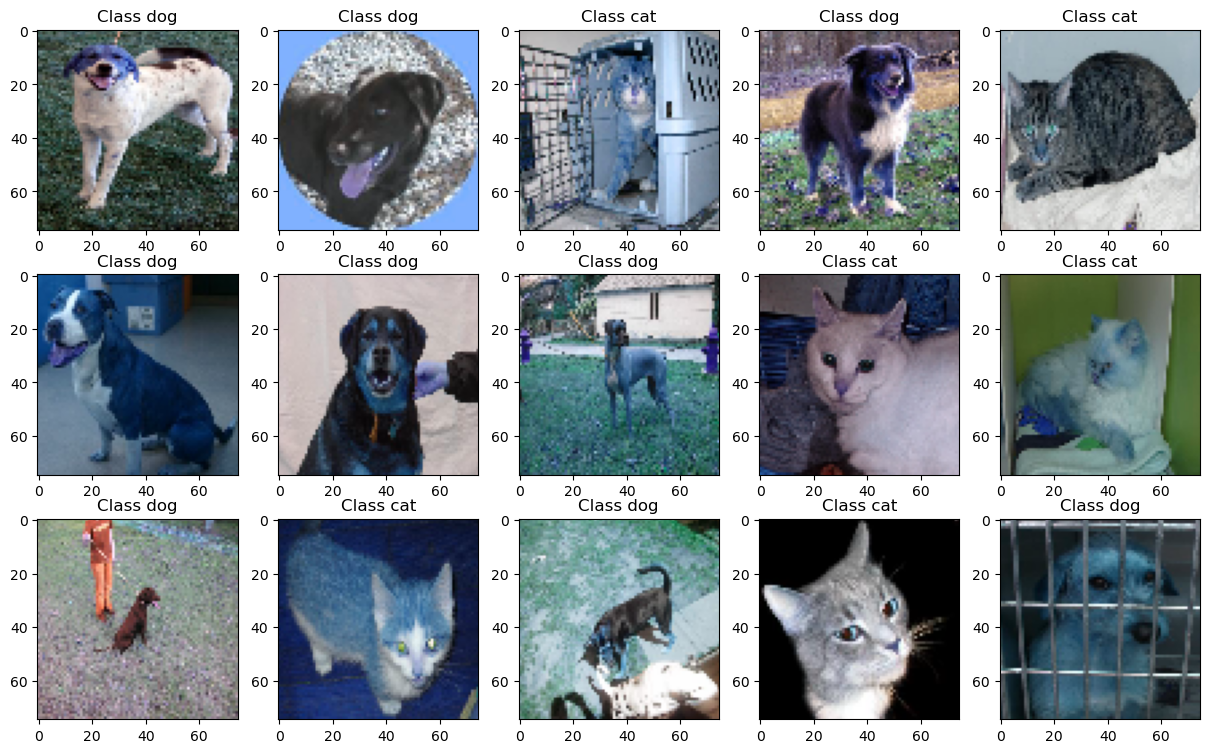

In [106]:
plt.figure(figsize=(15,9))
for i in range(1, 16):
    plt.subplot(3,5, i)
    r = np.random.randint(len(X_test))
    x = X_test[r]
    yhat = modelSGD.predict(np.array([x]))
    cP = 'cat' if np.argmax(yhat) == 0 else 'dog'
    cA = 'cat' if np.argmax(Y_test[r]) == 0 else 'dog'
    if cP != cA:
        plt.title(f"Class {cP} (act: {cA})")
    else:
        plt.title(f"Class {cP}")
    plt.imshow(x)
    

### Adam Optimizer

In [109]:
optAdam = keras.optimizers.Adam(learning_rate=0.0001)
modelAdam = createTLNN(optAdam)

In [110]:
modelAdam.fit(X_train, Y_train, batch_size=32, epochs=10,
          verbose=1)

Epoch 1/10
624/624 [==============================] - 25s 36ms/step - loss: 0.3174 - accuracy: 0.8665
Epoch 2/10
624/624 [==============================] - 21s 34ms/step - loss: 0.1224 - accuracy: 0.9507
Epoch 3/10
624/624 [==============================] - 21s 34ms/step - loss: 0.0640 - accuracy: 0.9774
Epoch 4/10
624/624 [==============================] - 21s 34ms/step - loss: 0.0394 - accuracy: 0.9864
Epoch 5/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0329 - accuracy: 0.9892
Epoch 6/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0280 - accuracy: 0.9901
Epoch 7/10
624/624 [==============================] - 21s 34ms/step - loss: 0.0227 - accuracy: 0.9928
Epoch 8/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0177 - accuracy: 0.9944
Epoch 9/10
624/624 [==============================] - 21s 33ms/step - loss: 0.0176 - accuracy: 0.9943
Epoch 10/10
624/624 [==============================] - 20s 33ms/step - loss: 0.016

In [111]:
modelAdam.evaluate(X_test, Y_test)

157/157 [==============================] - 5s 25ms/step - loss: 0.4134 - accuracy: 0.9051


[0.4134325683116913, 0.9050670862197876]

1/1 [==============================] - 0s 23ms/step


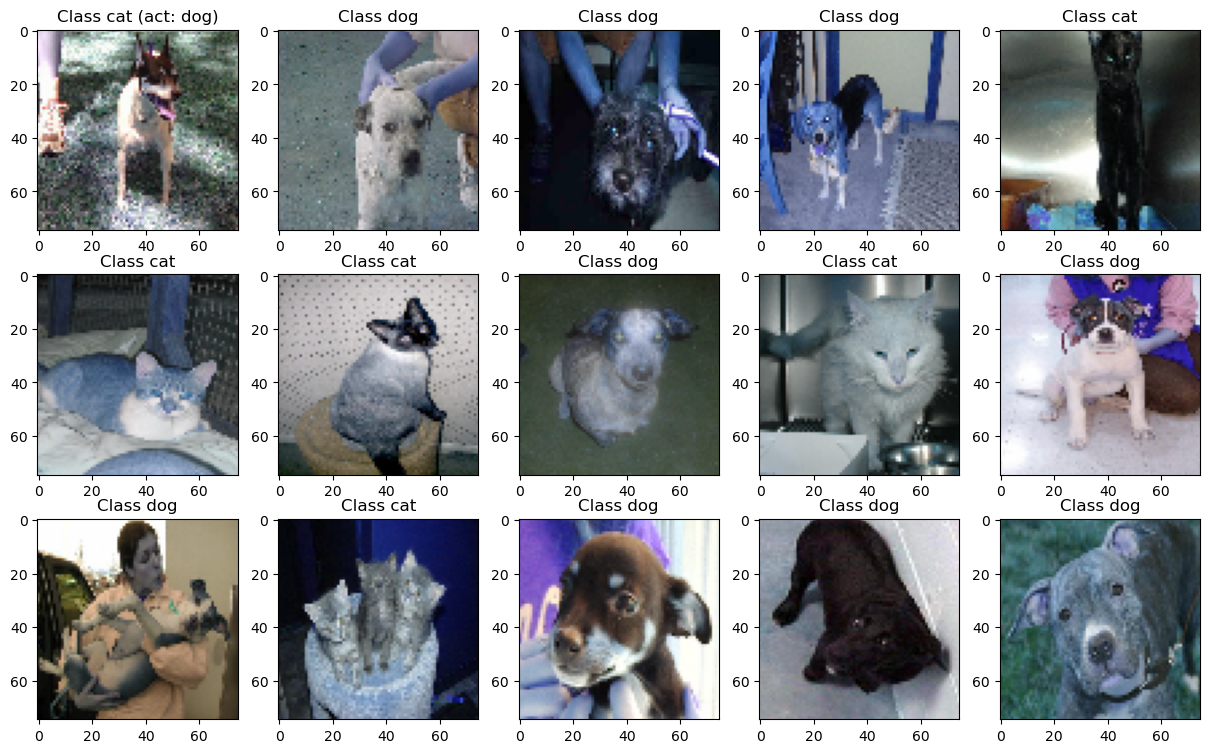

In [112]:
plt.figure(figsize=(15,9))
for i in range(1, 16):
    plt.subplot(3,5, i)
    r = np.random.randint(len(X_test))
    x = X_test[r]
    yhat = modelAdam.predict(np.array([x]))
    cP = 'cat' if np.argmax(yhat) == 0 else 'dog'
    cA = 'cat' if np.argmax(Y_test[r]) == 0 else 'dog'
    if cP != cA:
        plt.title(f"Class {cP} (act: {cA})")
    else:
        plt.title(f"Class {cP}")
    plt.imshow(x)
    